# EDA Gold Rate and forecast
---
This notebook contains Exploratory Data Analysis of Gold rates of six countries based on their currency: United States, Europe, Great Britian, India, UAE and China as well as forecasting using XGBoost.

I'm also interested in how price affected during COVID-19.

### Information about the data
* date - Date
* USD - Price of gold in US dollars
* EUR - Price of gold in Euros
* GBP - Price of gold in Pounds
* INR - Price of gold in Rupees
* AED - Price of gold in Dirhams
* CNY - Price of gold in Chinese Yuans.

### Import Module

In [1]:
# Core
import sys
import pandas as pd
import numpy as np
import os
import time
import math
from datetime import date,datetime,timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
%matplotlib inline

pd.options.mode.chained_assignment = None

### Reading input file

In [2]:
# Path of file to read
path = os.getcwd()

# Load data into pandas dataframe
daily = pd.read_csv(os.path.join(path, 'daily_gold_rate.csv'))
annual = pd.read_csv(os.path.join(path, 'annual_gold_rate.csv'))

---

## Explore the data

We first explore the data to make sense of them we will mainly looking at:
1. Understanding data and its type.
2. Check for missing or null.
3. Find potential outliers.
4. Find correlations.
5. Check for data skew.

### Prelim Observation

In [3]:
daily.head()

,Date,USD,EUR,GBP,INR,AED,CNY
0,1985-01-01,308.30,402.45,266.01,3825.85,1134.42,NaN
1,1985-01-02,305.50,401.49,266.00,3787.05,1134.42,NaN
2,1985-01-03,302.30,397.08,262.76,3718.88,1107.67,NaN
3,1985-01-04,303.15,397.15,262.58,3759.64,1118.21,NaN
4,1985-01-07,298.25,392.55,261.17,3741.23,1091.58,835.8


In [4]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9704 entries, 0 to 9703
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9704 non-null   object 
 1   USD     9704 non-null   float64
 2   EUR     9704 non-null   float64
 3   GBP     9704 non-null   float64
 4   INR     9704 non-null   float64
 5   AED     9704 non-null   float64
 6   CNY     9700 non-null   float64
dtypes: float64(6), object(1)
memory usage: 530.8+ KB


In [5]:
daily.describe()

,USD,EUR,GBP,INR,AED,CNY
count,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9700.000000
mean,754.900371,624.274441,499.861527,39440.737164,2772.562061,4987.779785
std,509.680400,414.592280,374.830318,38459.177898,1872.224258,3378.756103
min,252.800000,222.200000,157.150000,3687.170000,928.530000,809.630000
25%,353.987500,305.247500,219.522500,11598.695000,1298.505000,2189.372500
50%,425.450000,362.085000,259.370000,17038.720000,1562.390000,3311.720000
75%,1234.925000,1016.015000,823.062500,75974.875000,4535.797500,8097.082500
max,2067.150000,1874.560000,1572.810000,156815.690000,7592.950000,14355.530000


There appear to be some missing data in CNY.
We can assume that there is no trade at that moment or official record got lost in time. We will fill them with 0

In [6]:
daily.fillna(0)

,Date,USD,EUR,GBP,INR,AED,CNY
0,1985-01-01,308.30,402.45,266.01,3825.85,1134.42,0.00
1,1985-01-02,305.50,401.49,266.00,3787.05,1134.42,0.00
2,1985-01-03,302.30,397.08,262.76,3718.88,1107.67,0.00
3,1985-01-04,303.15,397.15,262.58,3759.64,1118.21,0.00
4,1985-01-07,298.25,392.55,261.17,3741.23,1091.58,835.80
...,...,...,...,...,...,...,...
9699,2022-03-07,1980.95,1821.48,1508.09,152468.77,7276.13,12516.24
9700,2022-03-08,2039.05,1874.56,1555.28,156815.69,7489.63,12874.97
9701,2022-03-09,1988.90,1800.64,1511.72,152282.61,7305.33,12562.39
9702,2022-03-10,1996.60,1812.04,1520.81,152350.57,7333.61,12622.21


In [7]:
annual.head()

,Date,USD,EUR,GBP,INR,AED,CNY
0,1978,193.44,124.73580,100.65449,NaN,NaN,NaN
1,1979,304.68,185.06142,143.09014,2481.90512,1163.93597,NaN
2,1980,614.50,378.19461,263.80259,4831.74943,2278.36795,NaN
3,1981,459.26,360.90588,227.01948,3966.64790,1691.03194,NaN
4,1982,375.30,345.59742,215.53232,3553.62680,1378.72895,NaN


In [8]:
annual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    44 non-null     int64  
 1   USD     44 non-null     float64
 2   EUR     44 non-null     float64
 3   GBP     44 non-null     float64
 4   INR     43 non-null     float64
 5   AED     43 non-null     float64
 6   CNY     37 non-null     float64
dtypes: float64(6), int64(1)
memory usage: 2.5 KB


In [9]:
annual.describe()

,Date,USD,EUR,GBP,INR,AED,CNY
count,44.000000,44.000000,44.000000,44.000000,43.000000,43.000000,37.000000
mean,1999.500000,692.055909,571.891313,450.575615,34026.445973,2585.786320,4950.991330
std,12.845233,486.226172,395.398741,357.907845,37476.310663,1783.571654,3377.322124
min,1978.000000,193.440000,124.735800,100.654490,2481.905120,995.506180,926.645180
25%,1988.750000,360.540000,302.387860,215.853185,6423.166690,1327.153290,2243.380520
50%,1999.500000,416.415000,359.622620,249.850690,12788.438900,1557.457900,3306.274890
75%,2010.250000,1176.175000,932.098448,761.273783,64728.547700,4379.206195,8283.158470
max,2021.000000,1798.610000,1549.044710,1378.980990,132967.875100,6606.550460,12205.481970


Again, some missing data we will deal with them the same as CNY daily.

In [10]:
annual.fillna(0)

,Date,USD,EUR,GBP,INR,AED,CNY
0,1978,193.44,124.73580,100.65449,0.00000,0.00000,0.00000
1,1979,304.68,185.06142,143.09014,2481.90512,1163.93597,0.00000
2,1980,614.50,378.19461,263.80259,4831.74943,2278.36795,0.00000
3,1981,459.26,360.90588,227.01948,3966.64790,1691.03194,0.00000
4,1982,375.30,345.59742,215.53232,3553.62680,1378.72895,0.00000
5,1983,423.66,439.89318,279.24936,4270.42821,1557.45790,0.00000
6,1984,360.78,425.91000,269.81553,4067.60433,1324.72272,0.00000
7,1985,317.30,394.08922,246.28501,3887.39270,1162.19778,926.64518
8,1986,367.85,351.34774,251.12483,4625.06990,1351.92474,1272.38854
9,1987,446.22,366.06607,272.49236,5761.91787,1641.52338,1659.60015


### Clean some data
Currently `Date` column is in incorrect datatype so we will correct that.

In [11]:
# Change to y/m/d date format
daily['Date'] = pd.to_datetime(daily['Date'], format="%Y-%m-%d")

---
## Visualization

I want to create range slider for graph thoughout different time period.
I found that using `plotly.graph_objects` is very easy. Simply create dict based on what you needed.
As I will create for all countries I will create function for this task.

In [12]:
# Function for create graph for currency

def plot_daily(currency):
    month = dict(count=1, label="1M", step="month", stepmode="backward")
    three_month = dict(count=3, label="3M", step="month", stepmode="backward")
    six_month = dict(count=6, label="6M", step="month", stepmode="backward")
    year = dict(count=1, label="1Y", step="year", stepmode="backward")
    three_year = dict(count=3, label="3Y", step="year", stepmode="backward")
    five_year = dict(count=5, label="5Y", step="year", stepmode="backward")
    alltime = dict(label="All time", step="all")
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=daily['Date'], y=daily[f'{currency}'], mode='lines'))
    fig.layout.update(title_text=f"Price of gold of {currency}")
    fig.update_layout(xaxis=dict(rangeselector=dict(buttons=list([month, three_month, six_month, year, three_year, five_year, alltime])), rangeslider=dict(visible=True), type="date"))
    fig.update_layout(yaxis_title=f'{currency}')
    fig.show()

### For seaborn
def plot_daily_sea_all(currency):
    fig = plt.figure(figsize=(12,6))
    g = sns.lineplot(x='Date', y=f'{currency}', data=daily)
    g.set_title(f"Price of gold of {currency}")
    g.set_xlabel("All time")
    g.set_ylabel(f'{currency}')
    plt.show()


In [13]:
currencies = ['USD', 'EUR', 'GBP','INR' , 'AED', 'CNY']

for i in currencies:
    plot_daily(i)

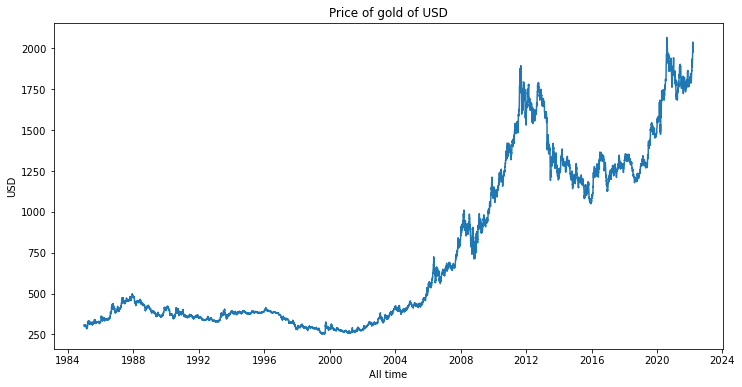

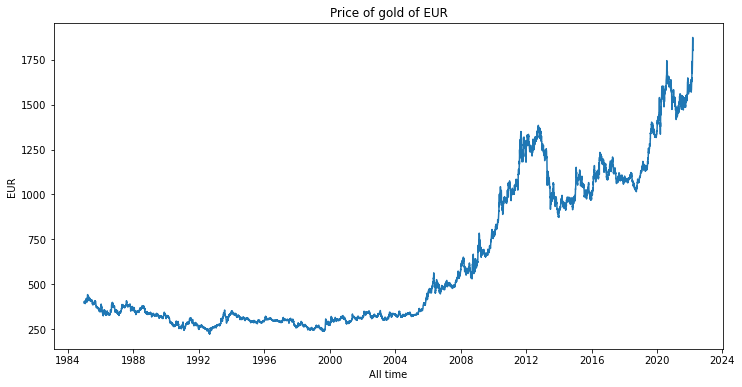

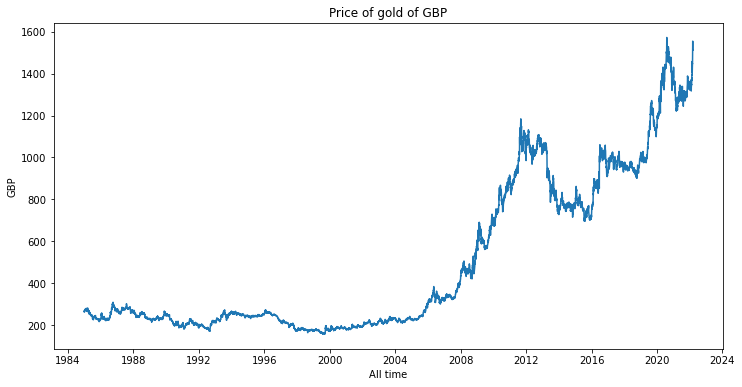

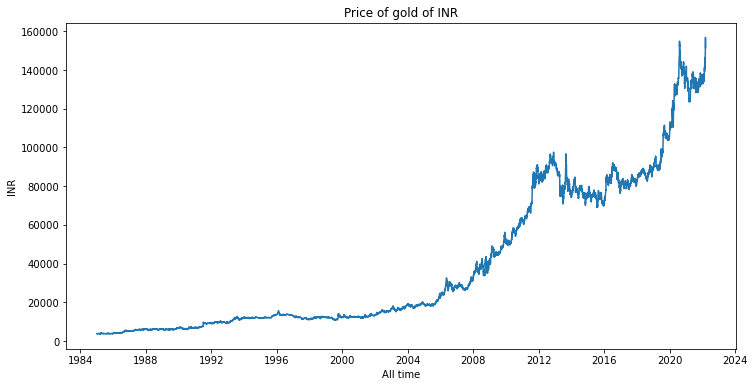

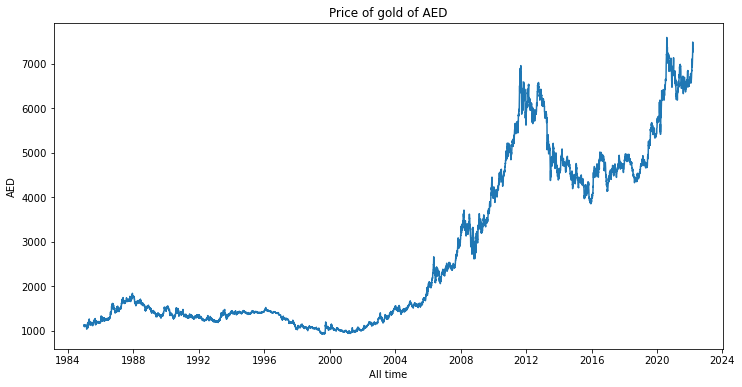

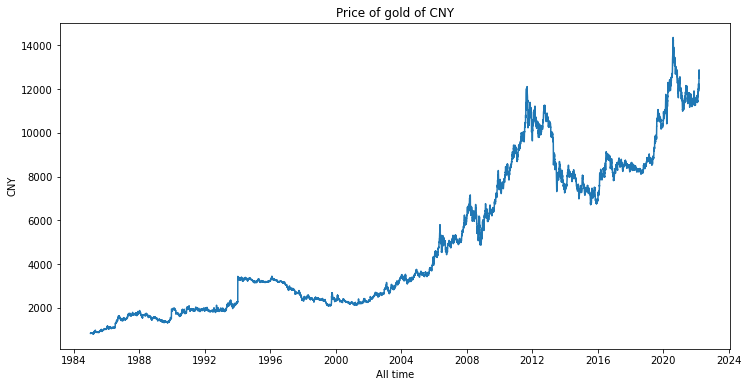

In [14]:
## Seaborn as Git don't show graph_objs
for i in currencies:
    plot_daily_sea_all(i)

### Asses Correlation

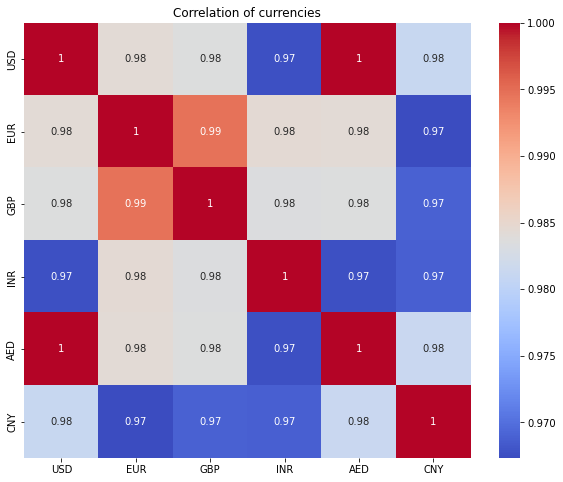

In [15]:
# Daily
correlation = daily.corr()
f, ax = plt.subplots(figsize=(10,8))
plt.title('Correlation of currencies')
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

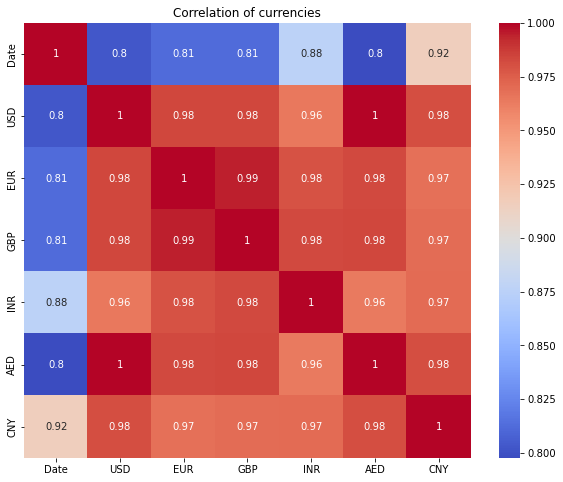

In [16]:
# Annual
correlation = annual.corr()
f, ax = plt.subplots(figsize=(10,8))
plt.title('Correlation of currencies')
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

There doesn't seem to be much different between daily ana annual data which make sense.
I will be mainly using daily dataset as it offer finer data and control.

### COVID Annual

We will be looking price during COVID-19 period which according to wikipedia start from December 2019 to Present.
[COVID-19 pandemic](https://en.wikipedia.org/wiki/COVID-19_pandemic)

To start of I will use annual dataset to simplify period that we will use (2019 - 2021).


In [17]:
COVID = annual[(annual['Date'] >= 2019) & (annual['Date'] <= 2021)]
COVID['Date'] = pd.to_datetime(COVID['Date'], format= "%Y")
COVID['Date'] = pd.DatetimeIndex(COVID['Date']).year

# Beware index Chain
# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas

In [18]:
COVID.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 41 to 43
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3 non-null      int64  
 1   USD     3 non-null      float64
 2   EUR     3 non-null      float64
 3   GBP     3 non-null      float64
 4   INR     3 non-null      float64
 5   AED     3 non-null      float64
 6   CNY     3 non-null      float64
dtypes: float64(6), int64(1)
memory usage: 192.0 bytes


In [19]:
# Create new column for % change per year
for currency in currencies:
    COVID[f'{currency}_%_change'] = COVID[f'{currency}'].pct_change() ## get % change per year (IE 0.1)
    COVID[f'{currency}_%_change'] = COVID[f'{currency}_%_change'].transform(lambda x : x * 100) ## transform to get percent
    COVID[f'{currency}_%_change'] = COVID[f'{currency}_%_change'].fillna(0)

In [20]:
COVID.head()

,Date,USD,EUR,GBP,INR,AED,CNY,USD_%_change,EUR_%_change,GBP_%_change,INR_%_change,AED_%_change,CNY_%_change
41,2019,1392.60,1244.87505,1092.92560,98108.1830,5115.16917,9634.22447,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
42,2020,1769.59,1549.04471,1378.98099,131199.9554,6499.95290,12205.48197,27.070946,24.433750,26.173363,33.72988,27.072100,26.688785
43,2021,1798.61,1520.62257,1307.53174,132967.8751,6606.55046,11600.56405,1.639928,-1.834817,-5.181308,1.34750,1.639974,-4.956117


In [21]:
COVID.describe()

,Date,USD,EUR,GBP,INR,AED,CNY,USD_%_change,EUR_%_change,GBP_%_change,INR_%_change,AED_%_change,CNY_%_change
count,3.0,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,2020.0,1653.600000,1438.180777,1259.812777,120758.671167,6073.890843,11146.756830,9.570291,7.532978,6.997352,11.692460,9.570692,7.244223
std,1.0,226.497881,168.009769,148.878293,19635.805195,831.986295,1344.357478,15.178176,14.665222,16.807768,19.096854,15.178829,17.020841
min,2019.0,1392.600000,1244.875050,1092.925600,98108.183000,5115.169170,9634.224470,0.000000,-1.834817,-5.181308,0.000000,0.000000,-4.956117
25%,2019.5,1581.095000,1382.748810,1200.228670,114654.069200,5807.561035,10617.394260,0.819964,-0.917409,-2.590654,0.673750,0.819987,-2.478058
50%,2020.0,1769.590000,1520.622570,1307.531740,131199.955400,6499.952900,11600.564050,1.639928,0.000000,0.000000,1.347500,1.639974,0.000000
75%,2020.5,1784.100000,1534.833640,1343.256365,132083.915250,6553.251680,11903.023010,14.355437,12.216875,13.086682,17.538690,14.356037,13.344393
max,2021.0,1798.610000,1549.044710,1378.980990,132967.875100,6606.550460,12205.481970,27.070946,24.433750,26.173363,33.729880,27.072100,26.688785


### Visualize

In [22]:
from plotly.subplots import make_subplots
def covid_graph(data, currency):
    fig = make_subplots(rows=1, cols=2)
    fig.add_trace(go.Bar(x=COVID['Date'], y=COVID[f'{currency}']),row=1,col=1)
    fig.add_trace(go.Bar(x=COVID['Date'], y=COVID[f'{currency}_%_change']),row=1,col=2)
    fig.update_xaxes(title_text="Year")
    fig.update_yaxes(title_text=f"Price of gold in {currency}",row=1,col=1)
    fig.update_yaxes(title_text=f"Percentage change of gold",row=1,col=2)
    fig.update_layout(title_text=f'Price and Percentage change of {currency}', showlegend=False)
    fig.show()


### For seaborn
def covid_annual_sea(data, currency):
    fig = plt.figure(figsize=(12,6))
    g = sns.barplot(x='Date', y=f'{currency}', data=data)
    g.set_title(f"Price of {currency}")
    g.set_xlabel("Year")
    g.set_ylabel(f'Price of gold in {currency}')

    plt.show()

def covid_annualpct_sea(data, currency):
    fig = plt.figure(figsize=(12,6))
    g1 = sns.barplot(x='Date', y=f'{currency}_%_change', data=data)
    g1.set_title(f"Percentage change of {currency}")
    g1.set_xlabel("Year")
    g1.set_ylabel(f'Percentage change of gold')
    plt.show()

for currency in currencies:
    covid_graph(COVID,currency)


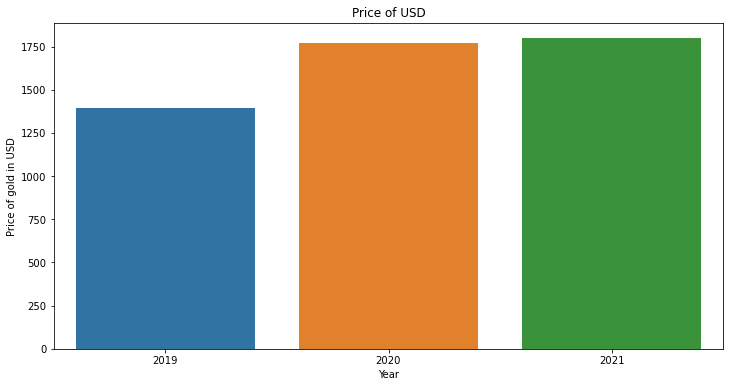

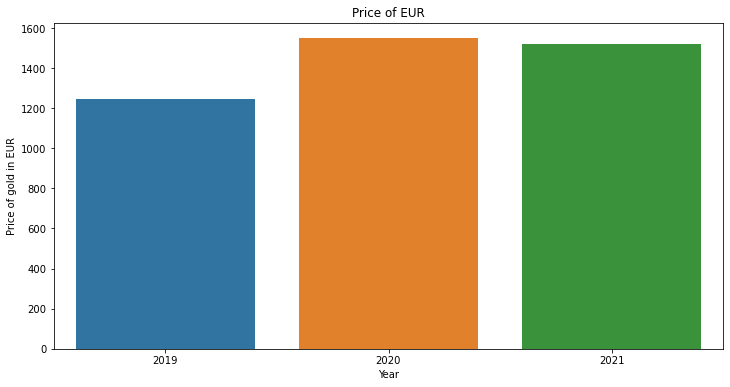

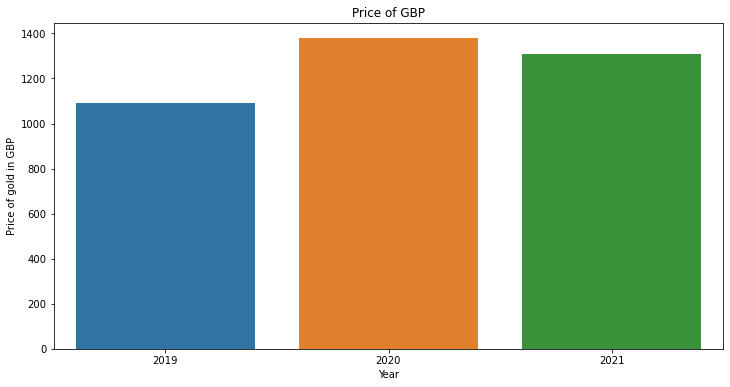

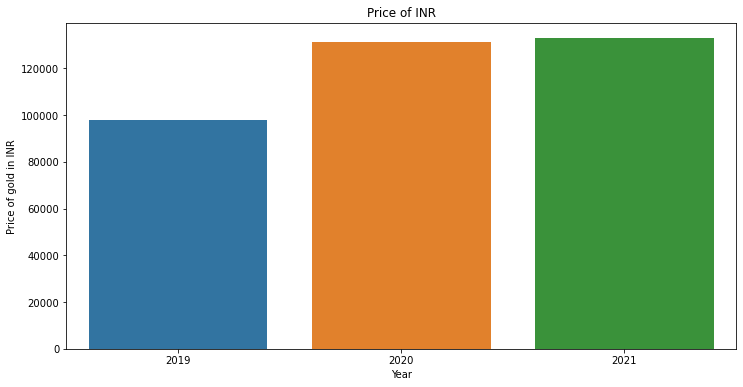

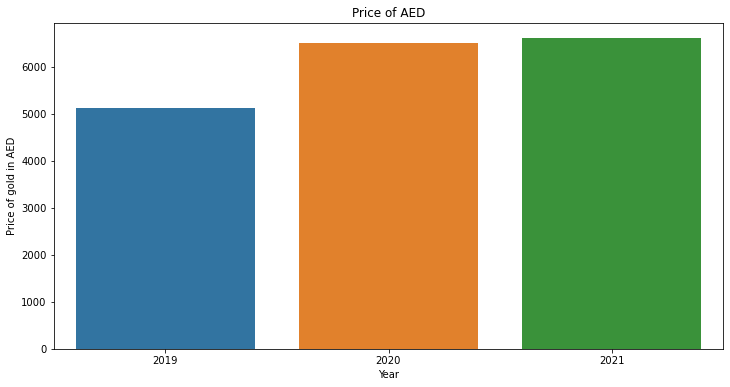

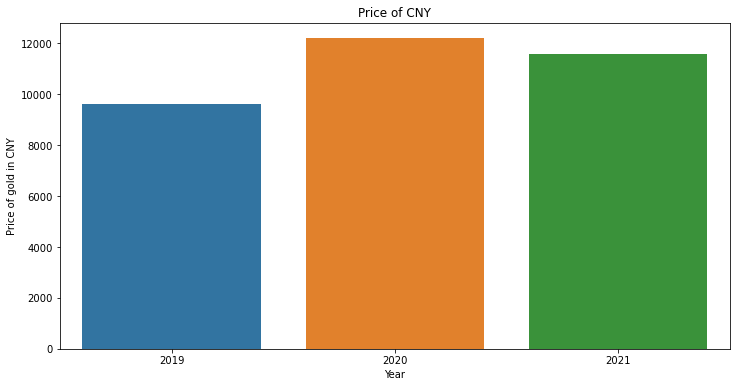

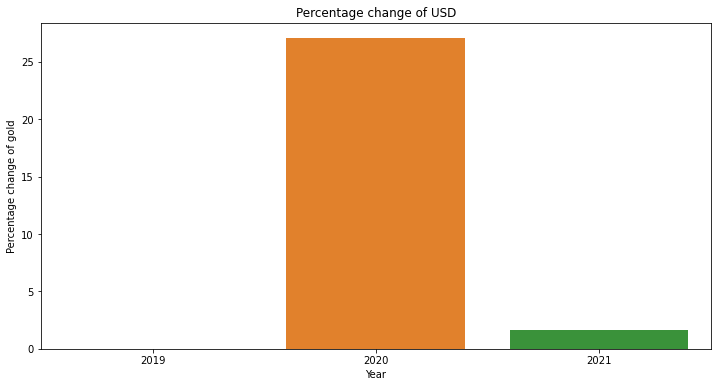

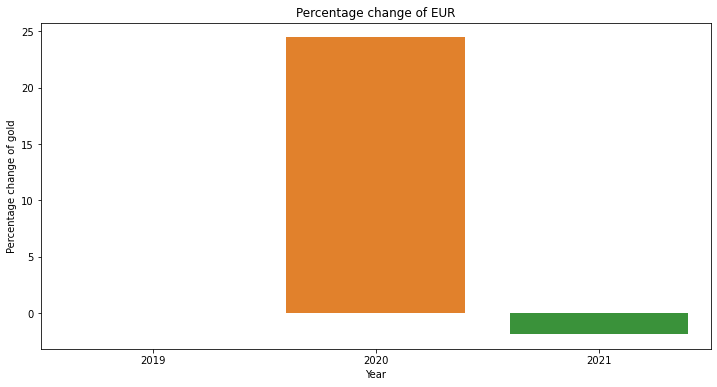

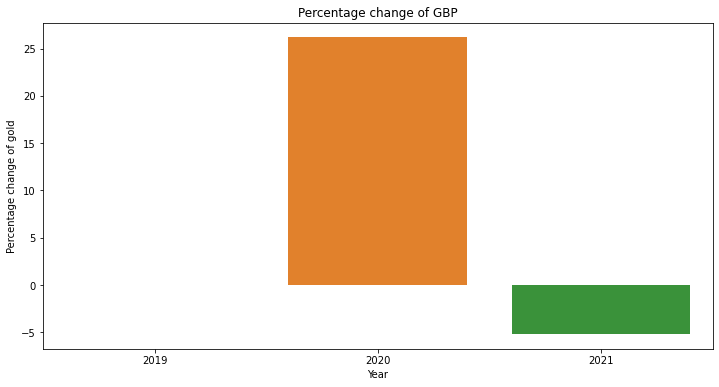

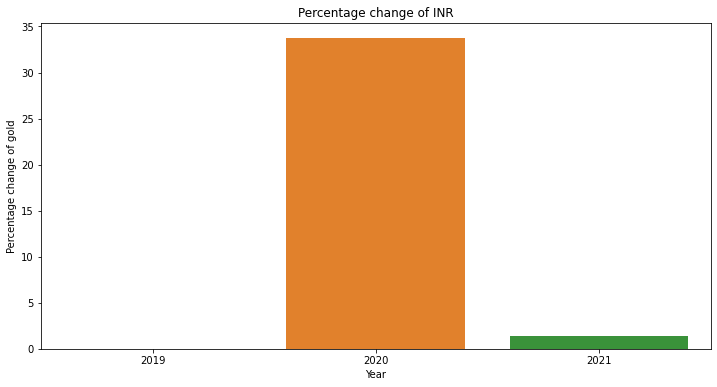

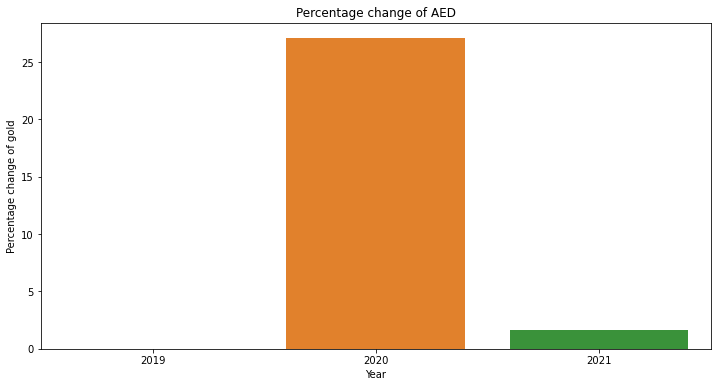

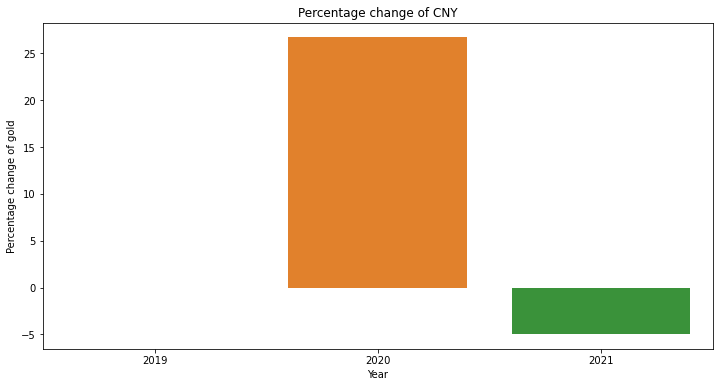

In [23]:
## Seaborn
for currency in currencies:
    covid_annual_sea(COVID, currency)

for currency in currencies:
    covid_annualpct_sea(COVID, currency)


---
## Modelling

In [24]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import plot_importance, plot_tree

### Train/Test Split

I will use 2015-01-01 as cutoff date.

In [25]:
split_date = '2015-01-01 00:00:00'
train = daily.loc[: split_date, :].copy()
test = daily.loc[split_date :, :].copy()

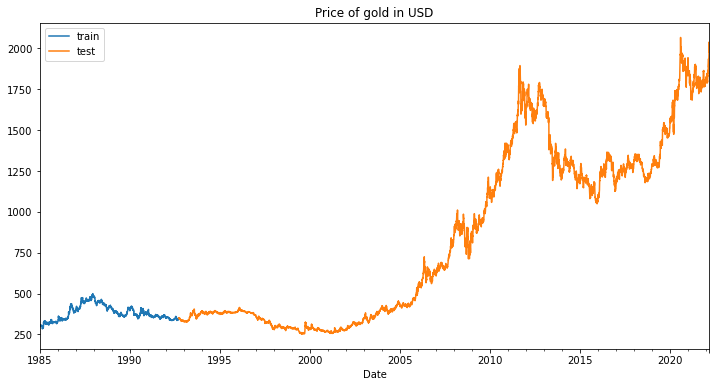

In [26]:
# Plot time series
fig, ax = plt.subplots(figsize=(12, 6))
train.plot(x='Date', y='USD', ax=ax, label='train')
test.plot(x='Date', y='USD', ax=ax, label='test')
ax.set_title('Price of gold in USD')
ax.legend();